<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/avian-flu-wild-birds-ireland 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Spatial analysis on the occurrence of Bird Flu in Ireland</p>

<img title="Wild Geese" src="img/wild-geese-pixabay_1149609_1920.jpeg" style="height:400px; border-radius: 5px" alt="">

---
# <p style="font-size:100%; text-align:left; color:#444444;">Contents:</p>

* [1. Introduction](#1)
* [2. Data Visualisation](#2)
    * [2.1 Proportion of captured birds with avian flu](#2.1)
    * [2.2 What species have shown to be the most affected by Bird Flu?](#2.2)
    * [2.3 What are the most frequent locations where captured birds have been targeted with Avian Flu?](#2.3)
    * [2.4 What are the months with the highest proportion of infected birds?](#2.4)
    * [2.5 Wild birds with avian flu have increased or have decreased in the past decade?](#2.5)
* [3. Geospatial data](#3)
    * [3.1 What is the proportion of birds targeted with Avian Flu on each Council / County?](#3.1)
    * [3.2 Which areas present a statistically significant presence of Bird Flu?](#3.2)
* [4. Conclusion](#4)

<a id="1"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">1- Introduction</p>

<img title="Department of Agriculture, Food and the Marine" src="img/department-of-agriculture-food-and-the-marine.png" alt="Department of Agriculture, Food and the Marine" align="right" style='height:150px; padding: 15px'> This analysis will investigate a dataset provided by Ireland's [Department of Agriculture, Food and the Marine](https://data.gov.ie/dataset/h5n1-wild-bird-species-identification) which contains the locations of bird species captured in Ireland from 1980-09-01 to 2020-01-27 and wild birds that are targeted for the H5N1 strain of avian flu.

According to the dataset's description: Avian influenza or **"Bird Flu"** is a contagious and often fatal viral disease of birds. Wild birds, particularly wild migratory water birds are considered to be the main reservoir of avian influenza viruses. There is a constant risk of avian influenza being introduced into Ireland from wild birds particularly from November onwards each year as this is when migratory birds arrive and congregate on wetlands, mixing with resident species.

To complement this risk analysis, a web scraping was performed to aggregate data from [BirdWatch Ireland](https://birdwatchireland.ie/) and spatial data about the administrative areas were provided by [Ordinance Survey Ireland](https://data-osi.opendata.arcgis.com/).

The notebook along with all data collection and preprocessing can be found [here](https://pessini.github.io/avian-flu-wild-birds-ireland/Datasets.html).

## Objective

The **aim** of this report is to map how this disease spread throughout the island and provide insights on possible spots and species that might need extra attention from the scientists who investigate this constant threat to resident birds.

## Questions

- What species have shown to be the most affected with Bird Flu?
- What are the most frequent locations where captured birds have been detected with Avian Flu?
- November is the month with the highest presence as mentioned? What are the months with the highest proportion of infected birds?
- The percentage of infected birds have increased during the years?
- What is the proportion of birds targeted with Avian Flu on each Council / County?
- Which areas present statistically significant incidence of Bird Flu?

In [1]:
# Libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.patches as mpatches

import json
from pathlib import Path

%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
import branca.colormap as cm
from PIL import Image

import libpysal as lps
import esda
from esda.getisord import G_Local

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Loading dataset
bird_flu = pd.read_pickle("./data/bird-flu.pkl")

<a id="2"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">2- Data Visualisation</p>

### Colour Palette

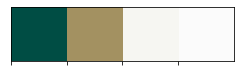

In [3]:
sns.palplot(['#004D44','#A39161','#F6F6F2','#FBFBFB']);

<a id="2.1"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">Proportion of captured birds with avian flu</p>

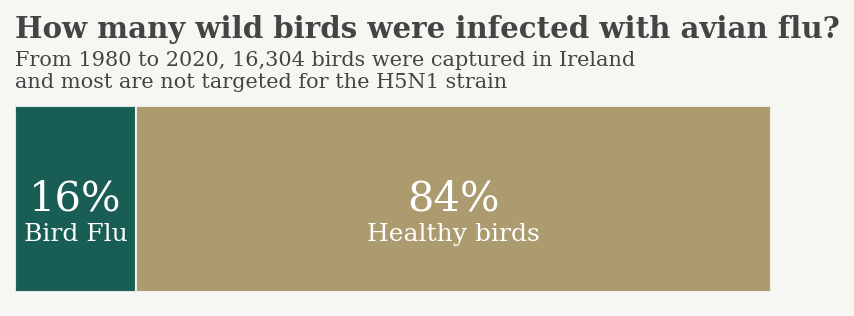

In [4]:
x=bird_flu.groupby(['target_H5_HPAI'])['target_H5_HPAI'].count()
y=len(bird_flu)
r=((x/y)).round(2)
ratio = pd.DataFrame(r).T

fig, ax = plt.subplots(1,1,figsize=(6.5, 1.8),dpi=150)
background_color = "#F6F6F2"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], color='#004D44', alpha=0.9, ec=background_color, label='Infected Birds')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='#A39161', alpha=0.9,ec=background_color, label='Healthy Birds')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i),va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Bird Flu", xy=(ratio[1.0][i]/2, -0.15),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')

for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Healthy birds", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.15),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')

subtitle = 'From 1980 to 2020, {:,} birds were captured in Ireland \nand most are not targeted for the H5N1 strain'.format(y)
fig.text(0.125,1.1,'How many wild birds were infected with avian flu?', fontfamily='serif',fontsize=14, fontweight='bold', color='#444444')
fig.text(0.125,0.915,subtitle,fontfamily='serif',fontsize=10, color='#444444')  
plt.show()

In [5]:
# Selecting only infected birds
infected_birds = bird_flu[bird_flu['target_H5_HPAI'] == 1]

In [9]:
infected_birds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 6 to 16292
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Scientific_Name       2585 non-null   object 
 1   Common_Name           2585 non-null   object 
 2   Date                  2585 non-null   object 
 3   Year                  2585 non-null   int64  
 4   Month                 2585 non-null   int64  
 5   Day                   2585 non-null   int64  
 6   Time                  2585 non-null   int64  
 7   Country               2585 non-null   object 
 8   Country_State_County  2585 non-null   object 
 9   State                 2585 non-null   object 
 10  County                2574 non-null   object 
 11  Locality              2585 non-null   object 
 12  Latitude              2585 non-null   float64
 13  Longitude             2585 non-null   float64
 14  Parent_Species        2585 non-null   object 
 15  target_H5_HPAI      

<a id="2.2"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">What species have shown to be the most affected by Bird Flu?</p>

In [8]:
infected_species = infected_birds.groupby('Common_Name').size().sort_values(ascending=False)

In [11]:
infected_species.sum()

2585

In [ ]:
def offset_img(x, y, img, ax, zoom, offset, pad=0.4):
    '''For adding  .png images to the graph.
    source: https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib'''

    #img = plt.imread(img)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', 
                        boxcoords="offset points", 
                        pad=pad)
    ax.add_artist(ab)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6),dpi=150)

background_color = "#F6F6F2"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color) 

# Top infected locations 
data = infected_species[:15]

high_c = '#004D44'
color_map = ['#A39161' for _ in range(len(data))]
color_map[0] = color_map[1] = color_map[2] = color_map[3] = high_c # color highlight

#highlight
ax.barh(data.loc[['Black-headed Gull', 'Mute Swan', 'Gray Heron', 'Little Egret']].index, data.iloc[:4], 
       edgecolor='darkgray',color=color_map, alpha=0.9, picker=True)
# actual
ax.barh(data.index, data, 
       edgecolor='white',color=color_map, alpha=0.3)

# base color text
for i in range(4,len(data)):
    ax.annotate(list(data)[i], xy=(data[i]-(data[i]*0.05), i),
                va = 'center', ha='right', fontweight='light',
                fontfamily='serif',fontsize=10, color='#FBFBFB')
    
# diff color text
for i in range(0,4):
    ax.annotate(list(data)[i], xy=(data[i]-(data[i]*0.05), i), 
                va = 'center', ha='right',fontweight='bold',
                fontsize=13, color='#FBFBFB')

ax.axes.get_xaxis().set_ticks([])
ax.invert_yaxis()

# Black-headed Gull
image = bird_flu.loc[bird_flu['Common_Name'] == 'Black-headed Gull', 'Image'].head(1)
image = image.item()
offset_img(x=250, y=9, img=image, ax=ax, zoom=0.14, offset=0)

plt.annotate('',xy=(310, 7.3), xytext=(325, 0.4), 
             arrowprops=dict(facecolor='#444444',arrowstyle="-",connectionstyle="angle3,angleA=90,angleB=0"), 
             fontsize=10,fontfamily='monospace',ha='center', color='#A39161')

for s in ['top', 'bottom', 'right']:
    ax.spines[s].set_visible(False)
    
ax.text(-100,-2.0,'Species captured where Avian Flu has been detected',
        fontfamily='serif',fontsize=14,fontweight='bold',color='#444444')

ax.text(-100, -1.4, 
        'Showing {} out of {} species with the highest Avian Flu incidence'.format(len(data),len(infected_species)), 
        fontfamily='serif',fontsize=10, color='#444444')

plt.show()

**Birds Species with more than 200 Bird Flu cases:**
- Black-headed Gull: 332 https://birdwatchireland.ie/birds/black-headed-gull/
- Mute Swan: 273 https://birdwatchireland.ie/birds/mute-swan/
- Gray Heron: 259 https://birdwatchireland.ie/birds/grey-heron/
- Little Egret: 227 https://birdwatchireland.ie/birds/little-egret/

**All 4 species** with the highest number of bird flu occurrences **are resident species** which indicates that migratory birds carrying the virus and mixing with local birds play an important role in spreading the disease.

<a id="2.3"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">What are the most frequent locations where captured birds have been targeted with Avian Flu?</p>

In [ ]:
top_infected_locations = infected_birds.groupby('Locality').size().sort_values(ascending=False)[:10]

In [ ]:
top_infected_locations.index

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6),dpi=150)

background_color = '#F6F6F2'
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color) 

# Top infected locations 
data = top_infected_locations

not_dublin = '#A39161'
color_map = ['#004D44' for _ in range(len(data))]
color_map[2] = color_map[6] = color_map[9] = not_dublin # color highlight

ax.barh(data.index, data, 
       edgecolor='white',color=color_map, alpha=0.8)

# diff color text
for i in range(0,10):
    ax.annotate(list(data)[i], 
                   xy=(data[i]-(data[i]*0.05), i), 
                   va = 'center', ha='right', fontweight='bold',fontfamily='serif',fontsize=10, color='#FBFBFB')

ax.axes.get_xaxis().set_ticks([])
ax.invert_yaxis()

for s in ['top', 'bottom', 'right']:
    ax.spines[s].set_visible(False)
    
ax.text(-60,-2.0,'Top 10 Locations where Avian Flu is most frequent',
        fontfamily='serif',fontsize=14,fontweight='bold',color='#444444')
ax.text(-60, -1.5, 
        '7 out of 10 locations with the highest presence of birds with avian flu are in Dublin.', 
        fontfamily='serif',fontsize=10, color='#444444')

custom_lines = [Line2D([0], [0], color='#004D44', lw=6),
                Line2D([0], [0], color=not_dublin, lw=6)]
ax.legend(custom_lines, ['Dublin', 'Other County'], 
          loc='lower right', facecolor='#F6F6F2', 
          edgecolor='#444444', borderpad=0.7)

plt.show()

<a id="2.4"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">What are the months with the highest proportion of infected birds?</p>

In [ ]:
def monthFormatter(month):
    """
    Take the representative number of a month and return its abbreviation
    """
    switcher = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec"
    }
    
    return switcher.get(month, "Invalid month")

In [ ]:
total_infected_bymonth = bird_flu.groupby(['Month', 'target_H5_HPAI']).size().rename("count")
prop_infected_bymonth = round(total_infected_bymonth / total_infected_bymonth.groupby(level=0).sum(),2)
prop_infected_bymonth = prop_infected_bymonth.iloc[1::2].reset_index(level='target_H5_HPAI', drop=True)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 6),dpi=150)

data = prop_infected_bymonth

background_color = "#F6F6F2"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)
color_map = ['#004D44' if value > 0.15 else '#A39161' for index, value in data.items()]

np.arange(len(data.index))

# # MONTH OVERVIEW
ax.bar(np.arange(len(data.index)), data, zorder=1, color=color_map, width=0.1)
ax.scatter(np.arange(len(data.index)), data, zorder=1,s=100, color=color_map)

ax.set_xticks(np.arange(len(data.index)))
ax.set_xticklabels(map(monthFormatter,list(data.index)),rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

ax.text(-1, 0.35, 'Monthly proportion of Infected Birds captured', fontsize=14, fontweight='bold', 
        fontfamily='serif', color='#444444')
ax.text(-1, 0.329, 
        'March, June, August, November and December are the months \nwith the highest proportion of captured birds with avian flu.', 
        fontfamily='serif',fontsize=10, color='#444444')

plt.hlines(y=0.15,xmin=0,xmax=12,lw=1,color='#444444')
plt.annotate('> 15% infected birds', xy=(12, 0.15), xytext=(10, 0.32), 
             arrowprops=dict(facecolor='#444444',arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=90"), 
             fontsize=10,fontweight='bold',fontfamily='serif',ha='center', color='#004D44')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

# plt.show()

<a id="2.5"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">Wild birds with avian flu have increased or have decreased in the past decade?</p>

In [ ]:
total_infected_byYear = bird_flu.groupby(['Year', 'target_H5_HPAI']).size().rename("count")
prop_infected_byYear = round(total_infected_byYear / total_infected_byYear.groupby(level=0).sum(),2)
prop_infected_byYear = prop_infected_byYear.iloc[::2].reset_index(level='target_H5_HPAI', drop=True).sort_index(ascending=True).filter(items=range(2009,2020), axis=0)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 6),dpi=150)
background_color = "#F6F6F2"
fig.patch.set_facecolor(background_color) # figure background color

data = prop_infected_byYear
data.index = data.index.map(str)
ax.set_facecolor(background_color)

ax.plot(data.index, data, color='#004D44', linewidth=2)
ax.scatter(data.index, data, zorder=1,s=100, color='#004D44')

ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(data.index,rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

plt.annotate('2015\n{:.0%} infected birds'.format(data['2015']), xy=(5.7, 0.23), xytext=(3.5, 0.20), 
             arrowprops=dict(facecolor='#444444',arrowstyle="->",connectionstyle="angle3,angleA=90,angleB=0"), 
             fontsize=10,fontfamily='serif',ha='center', color='#A39161')

for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
    
ax.text(-1, 0.26, '% of Infected Birds captured: 10-Years-Overview', fontsize=14, 
         fontweight='bold', fontfamily='serif', color='#444444')
ax.text(-1, 0.248, 
        'Captured birds with Avian Flu from 2009 to 2019.\nAfter 2012, the number of infected birds have been increasing until reach its peak in 2015.', 
        fontsize=10, fontfamily='serif', color='#444444')

plt.xticks(rotation=0)
plt.show()

<a id="3"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">3- Geospatial data</p>

In [ ]:
import topojson as tp

In [ ]:
admin_areas_json = 'data/Administrative_Areas_Ireland.json'
try:
    f = open(admin_areas_json, 'rb')
    with f:
        admin_areas = gpd.read_file(f, driver='GeoJSON')
except FileNotFoundError:
    print(f"File {admin_areas_json} does not exist.")

In [ ]:
# TOLERANCE = 0.1
# admin_areas["geometry"] = admin_areas.geometry.simplify(tolerance=TOLERANCE,preserve_topology=True)
# ALERT: the result contains gaps between the polygons.
# Using a topology aware simplification algorithm from topojson package to avoid this.

In [ ]:
admin_areas["geometry"]

In [ ]:
# topo = tp.Topology(admin_areas["geometry"].to_crs({'init':'epsg:29902'}), prequantize=False)
topo = tp.Topology(admin_areas["geometry"], prequantize=False)
# topo = tp.Topology(admin_areas["geometry"], prequantize=200)

In [ ]:
# simple = topo.toposimplify(1).to_gdf()
simple = topo.toposimplify(
    epsilon=1,
    simplify_algorithm='vw', 
    simplify_with='simplification', 
    prevent_oversimplify=True
)
simple

In [ ]:
simple = topo.toposimplify(1).to_gdf()

In [ ]:
admin_areas["geometry"] = simple["geometry"].set_crs(epsg=29902, inplace=True)

In [ ]:
avian_flu = infected_birds.copy()
admin_areas.drop(['GAEILGE', 'PROVINCE', 'GUID', 'CENTROID_X', 'CENTROID_Y', 'AREA', 'CC_ID', 'Shape__Area', 'Shape__Length'], axis='columns', inplace=True)
admin_areas.rename(columns = {'CONTAE': 'gaeilge', 'ENGLISH': 'council', 'OBJECTID': 'id'}, inplace = True)
admin_areas.columns = map(str.lower, admin_areas.columns)

In [ ]:
admin_areas['council'] = admin_areas['council'].str.title()
admin_areas['county'] = admin_areas['county'].str.title()
admin_areas['prop_infected'] = admin_areas.apply(lambda row: row.infected_birds / row.total_birds if row.total_birds > 0 else 0, axis = 1)
admin_areas['prop_healthy'] = admin_areas.apply(lambda row: row.healthy_birds / row.total_birds if row.total_birds > 0 else 0, axis = 1)
admin_areas['label_prop_healthy'] = admin_areas.apply(lambda row: f'{round(row.prop_healthy * 100, 2)}%', axis=1)
admin_areas['label_prop_infected'] = admin_areas.apply(lambda row: f'{round(row.prop_infected * 100, 2)}%', axis=1)

In [ ]:
# Getting Latitude and Longitude Mean to set the initial position of the map
mean_latitude = avian_flu['Latitude'].mean()
mean_longitude = avian_flu['Longitude'].mean()

#map_width, map_height = 700, 700
#admin_areas = admin_areas.to_crs({'init': 'epsg:29902'})

<a id="3.1"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">Choropleth map showing the proportion of captured birds targeted with Avian Flu in Ireland</p>

In [ ]:
colormap = cm.linear.OrRd_04.to_step(data=admin_areas['prop_infected'], method='quant', quantiles=[0,0.1,0.5,0.9,0.98,1])
#colormap = cm.linear.OrRd_03.to_step(data=admin_areas['prop_infected'], method='linear', n=5)
#print('Color scale representing the proportion of captured birds targeted with Avian Flu in Ireland.\n')
#colormap

In [ ]:
#fig = folium.Figure(width=850, height=850)
mymap = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=7,tiles=None)
#.add_to(fig)
folium.TileLayer('CartoDB positron',name='Light Map',control=False).add_to(mymap)

style_function = lambda x: {'weight':0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties']['prop_infected']), 
                            'fillOpacity':0.75}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

choropleth = folium.features.GeoJson(
    admin_areas,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(fields=['council','county','gaeilge','label_prop_infected'],
        aliases=['Council','County','Gaeilge','% of Infected Birds'],
        style=('background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;'),
        sticky=True
    )
)

colormap.caption = "Proportion of Infected Birds on each Council/County"

colormap.add_to(mymap)
mymap.add_child(choropleth)
mymap

In [ ]:
mymap.save('maps/choropleth_map.html')

In [ ]:
#roscommon_data = infected_birds[infected_birds['County'] == 'Roscommon']
#roscommon_data.groupby('Common_Name').size().sort_values(ascending=False)

In [ ]:
#sligo_data = infected_birds[infected_birds['County'] == 'Sligo']
#sligo_data.groupby('Common_Name').size().sort_values(ascending=False)

In [ ]:
#dublin_data = infected_birds[infected_birds['County'] == 'Dublin']
#dublin_data.groupby('Common_Name').size().sort_values(ascending=False)

In [ ]:
# roscommon = admin_areas[admin_areas['county'] == 'Roscommon']
# sligo = admin_areas[admin_areas['county'] == 'Sligo']
# dublin = admin_areas[admin_areas['county'] == 'Dublin']

In [ ]:
#roscommon

In [ ]:
#dublin

In [ ]:
#sligo

In **Roscommon/Ros Comáin** we see the highest proportion of infected birds and [Mute Swan](https://birdwatchireland.ie/birds/mute-swan/) represents almost half of the birds detected with Avian Flu.

Following the counties with the highest proportion is **Sligo/Sligeach** and [Whooper Swan](https://birdwatchireland.ie/birds/whooper-swan/) the species with the highest number. According to BirdWatch's website, Whooper Swan is a winter visitor to wetlands throughout Ireland from October to April. On the other hand, Mute Swan is an Irish resident.

In **Dublin/Baile Átha Cliath**, 3 species have the highest rate of infection and all of them are residents:

1. [Little Egret](https://birdwatchireland.ie/birds/little-egret/) - Resident along coasts and rivers throughout Ireland, but still scarce in the Midlands and north-west of the country. Little Egret was considered rare in Ireland until it first started breeding here in 1997. It has since expanded and now occurs in almost every coastal county, as well as at many inland sites.
2. [Gray Heron](https://birdwatchireland.ie/birds/grey-heron/) - Common resident at wetlands, estuaries and along rivers throughout Ireland.
3. [Black-headed Gull](https://birdwatchireland.ie/birds/black-headed-gull/) - Resident along all Irish coasts, with significant numbers arriving from the Continent in winter.

<a id="3.2"></a>
## <p style="font-size:100%; text-align:left; color:#444444;">Local indicators of spatial correlation - Hot Spot Analysis</p>

A cluster can be random and, to gather more meaningful information, we can apply hot spot analysis which reveals areas that could unlikely be random.

**Hot Spot Analysis** - given a set of weighted features, identifies statistically significant hot spot and cold spots using Getis-Ord G* statistic

**Hypothesis** - null hypothesis
Complete Spatial Randomness - What are the chances of this pattern is a result of a random spatial process? How likely would it be to get this same pattern base on random chances?

> "...everything is related to everything else, but near things are more related than distant things." - The First Law of Geography, according to Waldo Tobler

In [ ]:
df = admin_areas
wq =  lps.weights.Queen.from_dataframe(df)

In [ ]:
y = df['prop_infected']

In [ ]:
lg = G_Local(y, wq, star=True)

In [ ]:
df['Z'] = lg.Zs
df['P'] = lg.p_sim

In [ ]:
def g_map(g, geog, ax, legend_loc=0):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on
    legend_loc : legend location

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = df.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='#bdbdbd', edgecolor=ec, linewidth=0.2)
    
    # Plot HH clusters
    hh = df.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='#f03b20', edgecolor=ec, linewidth=0.2)
    
    # Plot LL clusters
    ll = df.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='#2c7fb8', edgecolor=ec, linewidth=0.2)

    ax.set_title('Getis-Ord G* statistic for % of Infected Birds', size=15)
    
    hotspot_patch = mpatches.Patch(color='#f03b20', label='hot spot')
    coldspot_patch = mpatches.Patch(color='#2c7fb8', label='cold spot')
    nsig_patch = mpatches.Patch(color='#bdbdbd', label='not significant')

    plt.legend(handles=[hotspot_patch, coldspot_patch, nsig_patch], loc=legend_loc, facecolor='#F6F6F2', 
          edgecolor='#444444', borderpad=0.7)
    
    plt.annotate('Sligo', xy=(-8.7, 54.2), xytext=(-9.2, 55.1), 
             arrowprops=dict(facecolor='#444444',arrowstyle="->",connectionstyle="angle3,angleA=90,angleB=0"), 
             fontsize=10,fontfamily='serif',ha='center', color='#f03b20')
    
    plt.annotate('Mayo', xy=(-9.3, 54), xytext=(-10, 54.5), 
             arrowprops=dict(facecolor='#444444',arrowstyle="->",connectionstyle="angle3,angleA=90,angleB=0"), 
             fontsize=10,fontfamily='serif',ha='center', color='#f03b20')
    
    plt.annotate('Longford', xy=(-7.8, 53.8), xytext=(-6.5, 54.7), 
             arrowprops=dict(facecolor='#444444',arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=90"), 
             fontsize=10,fontfamily='serif',ha='center', color='#f03b20')
    
    ax.set_axis_off()
    return ax

In [ ]:
# Setup figure and axes
fig, ax = plt.subplots(1,1, figsize=(8, 8),dpi=150)
ax = g_map(lg, df, ax, 4)
# Render
plt.show()

In [ ]:
# Sligo - Z = 2.853354 / p-value = 0.017
# Mayo - Z = 2.175596 / p-value = 0.025
# Longford - Z = 1.563024 / p-value = 0.031

In [ ]:
hotspots = df[(df['P'] < 0.05) & (df['Z'] > 0)]
coldspots = df[(df['P'] < 0.05) & (df['Z'] < 0)]
#hotspots

**z = standardized G statistic in Getis & Ord (1992)**

**p-value < 0.05 - statistically significant**

### Hot Spots
- Sligo / Sligeach ( z = 1.353464 / p-value = 0.033 ) 
- Mayo / Maigh Eo ( z = 1.031976 / p-value = 0.020 )
- Longford / An Longfort ( z = 0.650739 / p-value = 0.028 )

### Cold Spots
- Laois / Laois ( z = -0.764141 / p-value = 0.018 )
- Carlow / Ceatharlach ( z = -0.675114 / p-value = 0.016 )
- Kilkenny / Cill Chainnigh ( z = -0.662391 / p-value = 0.035 )
- Louth / Lú ( z = -0.411557 / p-value = 0.019 )

<a id="4"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">4- Conclusion</p>

The data shows that despite the concern about migrant wild birds carrying the "Bird Flu" virus being a potential pandemic threat, resident species have shown the highest number of infections which indicates there is a high risk of possible Bird Flu outbreaks in Ireland.

November and December are the months that need extra attention as stated by Ireland's Department of Agriculture, Food and the Marine but, even during the summer (June and August), the presence of infected birds was detected with high rates of infection among captured birds.

After reaching a peak of infection rate in 2015, the infection rate has presented stable between 14% and 18% from 2016 to 2019.

Although Sligo/Sligeach and Roscommon/Ros Comáin have presented the highest rate of infections, 3 counties were marked as hot spots, and especially Sligo and Mayo could be considered possible entering routes for the disease.

---
<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/avian-flu-wild-birds-ireland) <br>Author: Leandro Pessini